# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
import graphviz
import collections
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from prettytable import PrettyTable
from sklearn.externals import joblib
from bs4 import BeautifulSoup
from graphviz import Source

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
LIMIT 100000
""", con)

In [4]:
print(display.shape)
display.head(3)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element


soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████| 87773/87773 [00:35<00:00, 2460.75it/s]


In [17]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Featurization

Before we apply various featurizations to the data we need to split the data appropriately
as train data, cross validation data and test data.

In [18]:
x = preprocessed_reviews
y = final["Score"].values

In [19]:
# splitting the data into 3 parts for furhter process, 
# train data, cross validation data and test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)         # this is random splitting
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.30) # this is random splitting



In [20]:
# number of rows in earch data set, train, cross validation and test data respectively
print(len(x_train))
print(len(x_cv))
print(len(x_test))

43008
18433
26332


## [4.1] BAG OF WORDS

In [21]:
#BoW
count_vect = CountVectorizer(max_features=5000) #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

x_train_bow = count_vect.transform(x_train)
x_test_bow  = count_vect.transform(x_test)
x_cv_bow    = count_vect.transform(x_cv)

print(x_train_bow.shape, y_train.shape)
print(x_cv_bow.shape, y_cv.shape)
print(x_test_bow.shape, y_test.shape)
print("="*50)


some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']
(43008, 5000) (43008,)
(18433, 5000) (18433,)
(26332, 5000) (26332,)


## [4.2] TF-IDF

In [22]:
# TFIDF using scikit-learn

tf_idf = TfidfVectorizer(max_features=5000) #arguments: ngram_range=(1,2), min_df=10                #in scikit-learn
tf_idf.fit(x_train)

print("some sample features",tf_idf.get_feature_names()[0:10])
print('='*50)

# we use fit() method to learn the vocabulary from x_train 
# and now transform text data to vectors using transform() method

x_train_tf = tf_idf.transform(x_train)
x_cv_tf    = tf_idf.transform(x_cv)
x_test_tf  = tf_idf.transform(x_test)

print("After featurization\n")

print(x_train_tf.shape, y_train.shape)
print(x_cv_tf.shape, y_cv.shape)
print(x_test_tf.shape, y_test.shape)
print("="*50)


some sample features ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']
After featurization

(43008, 5000) (43008,)
(18433, 5000) (18433,)
(26332, 5000) (26332,)


## [4.3] Word2Vec

In [24]:
# Train your own Word2Vec model using your own text corpus

list_of_sentance_train =[]

for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

In [25]:
# this line of code trains your w2v model on the give list of sentances
w2v_model = Word2Vec(list_of_sentance_train, min_count=5, size=50, workers=-1)

In [26]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9890
sample words  ['product', 'delivered', 'makes', 'good', 'sense', 'less', 'expensive', 'no', 'need', 'carry', 'multiple', 'smaller', 'bags', 'floor', 'plenty', 'hand', 'little', 'girls', 'love', 'healthy', 'advertised', 'pack', 'one', 'big', 'box', 'not', 'sure', 'getting', 'amazon', 'best', 'idea', 'pretty', 'well', 'smashed', 'time', 'got', 'really', 'like', 'taste', 'wife', 'said', 'stick', 'original', 'flavor', 'chili', 'grocery', 'store', 'although', 'originally', 'hoping']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

Converting Train data

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 26683/26683 [00:40<00:00, 663.60it/s]


(26683, 50)
[ 4.63802545e-04 -9.14620302e-05  8.39857914e-04 -2.11066650e-03
  1.01099800e-03 -6.99112447e-04  1.13057534e-04 -2.33749658e-03
  2.46977802e-04  2.16758822e-03 -9.14224789e-04  5.02322967e-05
 -1.28661920e-03 -1.52936805e-04 -5.33212005e-04 -1.95643255e-03
 -1.45448138e-03 -1.25641440e-03  3.01827744e-03 -3.62509658e-04
 -4.10847578e-04 -1.20700525e-03  5.90623898e-04 -3.58277544e-04
  1.13798814e-03  1.92258023e-04  1.75686782e-03 -2.34484246e-03
  7.88958533e-04 -2.46655214e-03  1.26468472e-03  3.14430194e-04
  8.09976467e-04 -3.97003982e-04  7.20299175e-05 -9.72705098e-04
  1.52828191e-03 -9.93454679e-05 -1.84080290e-03 -3.41153529e-04
 -8.03170251e-04 -2.46339480e-04  8.02687224e-04 -9.53865501e-06
  8.71069885e-05  2.27060837e-03 -1.60051999e-03  1.03006133e-03
 -5.10094745e-04  2.32021042e-03]


Converting cross validation data

In [29]:

list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 11436/11436 [00:17<00:00, 636.61it/s]


(11436, 50)
[-1.03242384e-03  3.76358931e-03 -2.51476260e-03  7.22119235e-05
 -1.89193665e-03  2.32164932e-03  2.25421861e-03 -2.65163422e-04
 -5.86674522e-04  5.77809577e-04 -3.34824047e-03  1.01221524e-03
  9.17985861e-04  3.56046323e-05 -4.93111245e-04 -4.17788737e-04
  1.98521387e-04  1.21198383e-03  2.75606750e-03  1.86832314e-03
 -1.17973682e-03  2.38594148e-03 -4.30947689e-04 -2.88512610e-04
 -8.74792400e-05  1.19795708e-03  1.19823990e-03 -1.05462315e-04
  4.44062208e-04 -6.00271113e-04  2.80353440e-03  5.97353471e-04
  1.02167947e-03 -2.81745021e-03  2.24260753e-04 -6.99884621e-04
 -1.74778040e-03 -1.05528993e-04  1.47424738e-03  1.69324661e-03
 -9.36819235e-04 -3.83133185e-04 -6.45952218e-04  9.84170855e-04
  2.44978852e-03 -1.17407600e-03 -8.01381940e-04 -1.09122740e-03
 -1.41872834e-03 -5.21935188e-05]


Converting test data

In [31]:

list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 16337/16337 [00:24<00:00, 653.73it/s]


(16337, 50)
[-3.29490924e-04  1.35128680e-03  1.91509802e-04 -1.07240085e-04
 -3.71133908e-05 -1.03080008e-03  1.06177745e-03 -4.98637289e-04
 -5.43941172e-04 -2.26938168e-04 -1.87221391e-04  2.15235642e-04
  3.61015919e-04 -1.41815911e-03 -7.01521644e-04 -5.20464557e-05
 -3.94306184e-04  6.87598424e-04  1.18277511e-03 -2.44187607e-06
 -1.03539405e-03 -4.20410591e-04 -7.47401327e-04  1.24861911e-04
  6.06622503e-04  1.66023103e-03  4.89868331e-04 -6.71348028e-04
  3.25429107e-05  7.30359683e-05  1.43803962e-03 -8.08677985e-04
 -6.92228650e-04  1.17659937e-03  1.39838197e-03  1.17497832e-03
  2.00884229e-03 -6.78563122e-04  1.09370656e-03  1.04497131e-04
 -1.42381500e-03 -2.09141948e-04 -6.80190001e-04  1.68796454e-03
  2.19503874e-04  1.42643027e-03  1.20387496e-03  7.92494045e-04
 -2.64997378e-04  3.88573043e-05]


#### [4.3.1.2] TFIDF weighted W2v

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

converting train data

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26683/26683 [07:38<00:00, 56.57it/s]


converting cross validation data

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 11436/11436 [03:18<00:00, 57.52it/s]


converting test data

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 16337/16337 [04:37<00:00, 58.96it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## Loading the Datasets using Joblib

In [3]:
#########################################    BoW   #######################################

x_train_bow = joblib.load('x_tr_bow100k.pkl')
x_test_bow  = joblib.load('x_te_bow100k.pkl')
x_cv_bow    = joblib.load('x_cv_bow100k.pkl')

y_train = joblib.load('y_train.pkl')
y_test  = joblib.load('y_test.pkl')
y_cv    = joblib.load('y_cv.pkl')

####################################### TF-IDF ##########################################

x_train_tf = joblib.load('x_tr_tfidf100k.pkl')
x_test_tf  = joblib.load('x_te_tfidf100k.pkl')
x_cv_tf    = joblib.load('x_cv_tfidf100k.pkl')

###################################### average w2v #####################################

sent_vectors_train = joblib.load('sent_vectors_train_100k.pkl')
sent_vectors_test  = joblib.load('sent_vectors_test_100k.pkl')
sent_vectors_cv    = joblib.load('sent_vectors_cv_100k.pkl')

##################################### tfidf w2v  #########################################

tfidf_sent_vectors_train = joblib.load('tfidf_sent_vectors_train_100k.pkl')
tfidf_sent_vectors_test  = joblib.load('tfidf_sent_vectors_test_100k.pkl')
tfidf_sent_vectors_cv    = joblib.load('tfidf_sent_vectors_cv_100k.pkl')


# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

* Tuning Hyperparameter using gridsearch cross validation, tuning Depth(parameter) first.

In [23]:
Depths = [10, 20, 21, 22, 23, 24, 25, 30, 40, 50]
param_grid = {'max_depth':Depths} #, 'mimin_samples_split':min_sam
clf = DecisionTreeClassifier(min_samples_split=50)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(x_train_bow, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_depth1 = grid.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth1)

Accuracy on train data =  78.17628360772643
The optimal number of depth is :  22


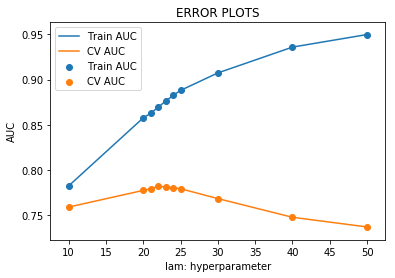

In [24]:
bow_auc_train = grid.cv_results_['mean_train_score']
bow_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(Depths, bow_auc_train, label='Train AUC')
plt.scatter(Depths, bow_auc_train, label='Train AUC')

plt.plot(Depths, bow_auc_cv, label='CV AUC')
plt.scatter(Depths, bow_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with Test data

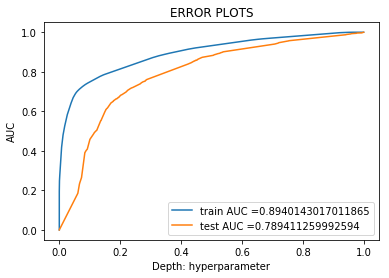

In [25]:
clf = DecisionTreeClassifier(max_depth = optimal_depth1, class_weight ='balanced', min_samples_split=150)
clf.fit(x_train_bow, y_train)

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion matrix

In [7]:
clf = DecisionTreeClassifier(max_depth = optimal_depth1, min_samples_split=150)
clf.fit(x_train_bow,y_train)

pred = clf.predict(x_test_bow)

acc_1 = accuracy_score(y_test, pred) * 100
pre_1 = precision_score(y_test, pred) * 100
rec_1 = recall_score(y_test, pred) * 100
f1_1  = f1_score(y_test, pred) * 100

print('\nAccuracy = %f%%' % (acc_1))
print('\nprecision= %f%%' % (pre_1))
print('\nrecall   = %f%%' % (rec_1))
print('\nF1-Score = %f%%' % (f1_1))


Accuracy = 85.557497%

precision= 88.899246%

recall   = 94.662757%

F1-Score = 91.690519%


* Hyperparamerter(min_split_size) tuning using GridSearchCV

In [8]:
min_split = [50, 75, 100, 150, 200, 250, 275, 300, 325, 350]
param_grid = {'min_samples_split': min_split} 
clf = DecisionTreeClassifier(max_depth=22)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(x_train_bow, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_split1 = grid.best_estimator_.min_samples_split
print("The optimal number of depth is : ",optimal_split1)

Accuracy on train data =  79.9392966150601
The optimal number of depth is :  325


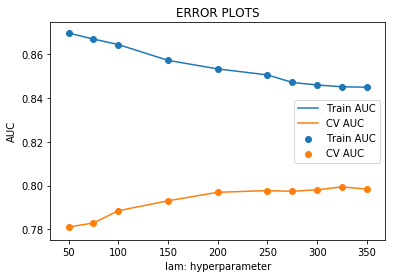

In [9]:
bow_auc_train = grid.cv_results_['mean_train_score']
bow_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(min_split, bow_auc_train, label='Train AUC')
plt.scatter(min_split, bow_auc_train, label='Train AUC')

plt.plot(min_split, bow_auc_cv, label='CV AUC')
plt.scatter(min_split, bow_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with test data

In [10]:
optimal_split1 = 200

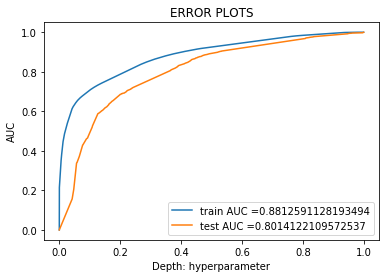

In [11]:
clf = DecisionTreeClassifier(max_depth = optimal_depth1, class_weight ='balanced', min_samples_split=optimal_split1)
clf.fit(x_train_bow, y_train)

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))

plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [118]:
parameters = {'min_samples_split': min_split,'max_depth': Depths}
grid = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'), parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid.fit(x_train_bow, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 20, 30, 40, 50],
                         'min_samples_split': [10, 15, 25

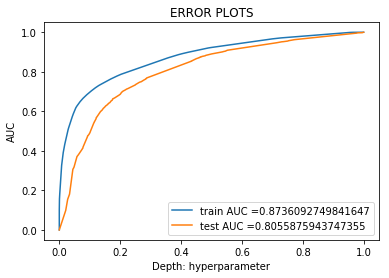

In [26]:
optimal_depth1=22
optimal_split1=300
clf = DecisionTreeClassifier(max_depth = optimal_depth1, class_weight ='balanced', min_samples_split=optimal_split1)
clf.fit(x_train_bow, y_train)

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))

plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [15]:
clf = DecisionTreeClassifier(max_depth = optimal_depth1, min_samples_split=optimal_split1)
clf.fit(x_train_bow,y_train)

pred = clf.predict(x_test_bow)

acc_1 = accuracy_score(y_test, pred) * 100
pre_1 = precision_score(y_test, pred) * 100
rec_1 = recall_score(y_test, pred) * 100
f1_1  = f1_score(y_test, pred) * 100

print('\nAccuracy = %f%%' % (acc_1))
print('\nprecision= %f%%' % (pre_1))
print('\nrecall   = %f%%' % (rec_1))
print('\nF1-Score = %f%%' % (f1_1))


Accuracy = 85.568890%

precision= 89.006414%

recall   = 94.531920%

F1-Score = 91.685993%


## Heatmaps for train data and test data

For train data:

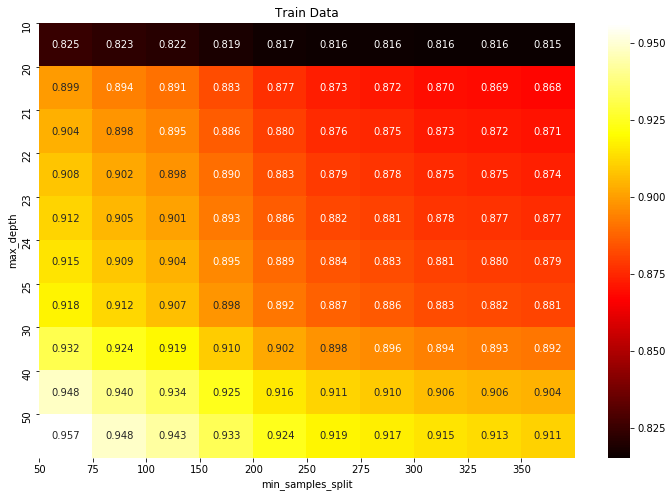

In [16]:
heat_map1 = grid.cv_results_['mean_train_score'].reshape(len(min_split),len(Depths))
plt.figure(figsize=(12,8))
sns.heatmap(heat_map1, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=min_split, yticklabels=Depths)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(min_split)), min_split)
plt.yticks(np.arange(len(Depths)), Depths)
plt.title('Heatmap of Train Data')
plt.show()

For test data:

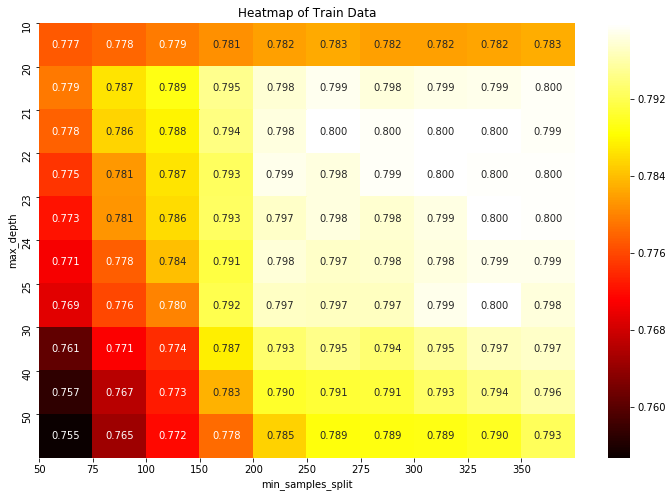

In [17]:
heat_map1 = grid.cv_results_['mean_test_score'].reshape(len(min_split),len(Depths))
plt.figure(figsize=(12,8))
sns.heatmap(heat_map1, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=min_split, yticklabels=Depths)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(min_split)), min_split)
plt.yticks(np.arange(len(Depths)), Depths)
plt.title('Heatmap of Train Data')
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [45]:
# feature importance
importances = clf.feature_importances_
indices = list(np.argsort(importances)[::-1][:20])
names = np.array(count_vect.get_feature_names())
print(names[indices])

['not' 'great' 'best' 'delicious' 'disappointed' 'perfect' 'love' 'good'
 'loves' 'nice' 'bad' 'favorite' 'excellent' 'wonderful' 'tasty' 'thought'
 'easy' 'tasted' 'would' 'amazing']


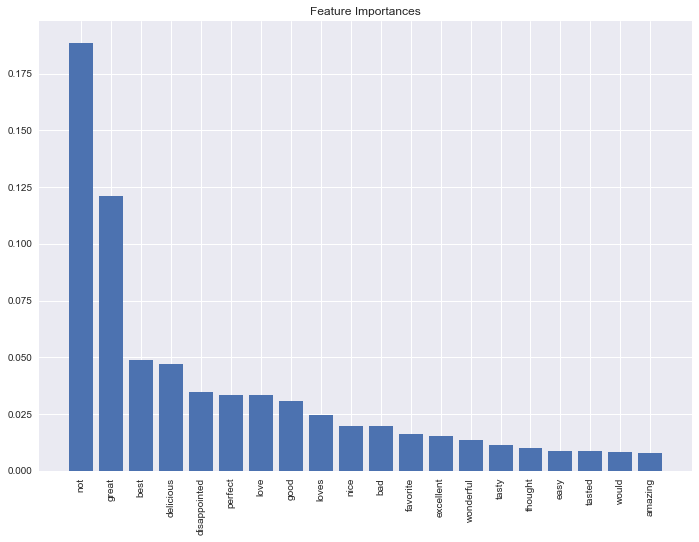

In [46]:
plt.figure()
plt.title("Feature Importances")
plt.bar(range(20), importances[indices])
plt.xticks(range(20), names[indices], rotation=90)
plt.show()

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

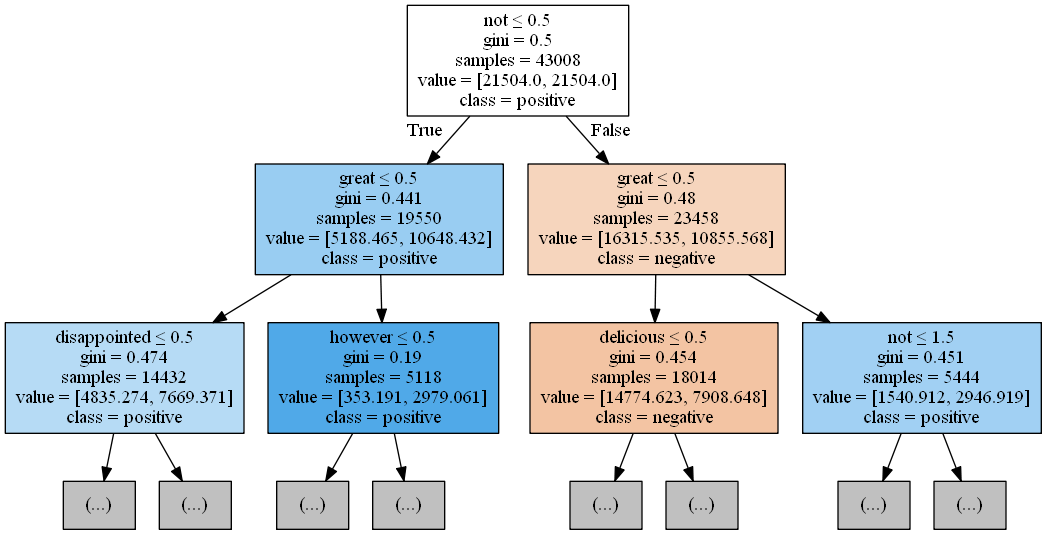

In [52]:
target = ['negative','positive']
# Create DOT data ############# feature_names= names[indices],
data = tree.export_graphviz(clf, max_depth=2, feature_names= names ,out_file=None,class_names=target,filled=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)  

# Show graph
Image(graph.create_png())


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

Hyperparameter tuning using grid serach cross validation for max_depth feature.

In [55]:
Depths = [10, 20, 21, 22, 23, 24, 25, 30, 40, 50]
param_grid = {'max_depth':Depths}
clf = DecisionTreeClassifier(min_samples_split=50)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(x_train_tf, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_depth2 = grid.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth2)

Accuracy on train data =  77.29089553475444
The optimal number of depth is :  24


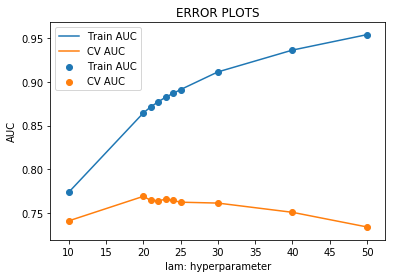

In [24]:
tf_auc_train = grid.cv_results_['mean_train_score']
tf_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(Depths, tf_auc_train, label='Train AUC')
plt.scatter(Depths, tf_auc_train, label='Train AUC')

plt.plot(Depths, tf_auc_cv, label='CV AUC')
plt.scatter(Depths, tf_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

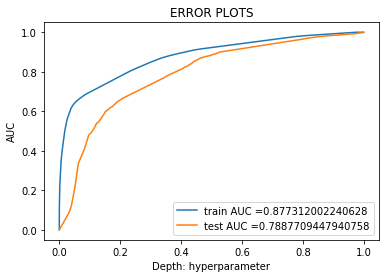

In [27]:
clf = DecisionTreeClassifier(max_depth = optimal_depth2, class_weight ='balanced', min_samples_split=300)
clf.fit(x_train_tf, y_train)

train_fpr_tf, train_tpr_tf, thresholds_tf = roc_curve(y_train, clf.predict_proba(x_train_tf)[:,1])
test_fpr_tf, test_tpr_tf, thresholds_tf = roc_curve(y_test, clf.predict_proba(x_test_tf)[:,1])

plt.plot(train_fpr_tf, train_tpr_tf, label="train AUC ="+str(auc(train_fpr_tf, train_tpr_tf)))
plt.plot(test_fpr_tf, test_tpr_tf, label="test AUC ="+str(auc(test_fpr_tf, test_tpr_tf)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [29]:
min_split = [50, 75, 100, 150, 200, 250, 275, 300, 325, 350]
param_grid = {'min_samples_split': min_split} 
clf = DecisionTreeClassifier(max_depth=22)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(x_train_tf, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_split2 = grid.best_estimator_.min_samples_split
print("The optimal number of splits is : ",optimal_split2)

Accuracy on train data =  79.18876053017347
The optimal number of splits is :  325


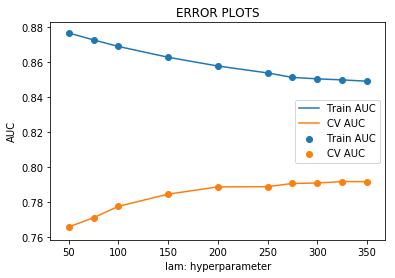

In [30]:
tf_auc_train = grid.cv_results_['mean_train_score']
tf_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(min_split, tf_auc_train, label='Train AUC')
plt.scatter(min_split, tf_auc_train, label='Train AUC')

plt.plot(min_split, tf_auc_cv, label='CV AUC')
plt.scatter(min_split, tf_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [34]:
optimal_split2 = 300

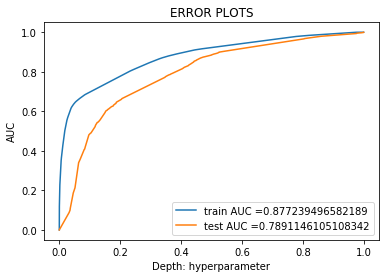

In [33]:
clf = DecisionTreeClassifier(max_depth = optimal_depth2, class_weight ='balanced', min_samples_split=300)
clf.fit(x_train_tf, y_train)

train_fpr_tf, train_tpr_tf, thresholds_tf = roc_curve(y_train, clf.predict_proba(x_train_tf)[:,1])
test_fpr_tf, test_tpr_tf, thresholds_tf = roc_curve(y_test, clf.predict_proba(x_test_tf)[:,1])

plt.plot(train_fpr_tf, train_tpr_tf, label="train AUC ="+str(auc(train_fpr_tf, train_tpr_tf)))
plt.plot(test_fpr_tf, test_tpr_tf, label="test AUC ="+str(auc(test_fpr_tf, test_tpr_tf)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [35]:
parameters = {'min_samples_split': min_split,'max_depth': Depths}
grid = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'), parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid.fit(x_train_tf, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 20, 21, 22, 23, 24, 25, 30, 40, 50],
                         'min_samples_split': [50, 7

In [36]:
grid.best_params_

{'max_depth': 20, 'min_samples_split': 350}

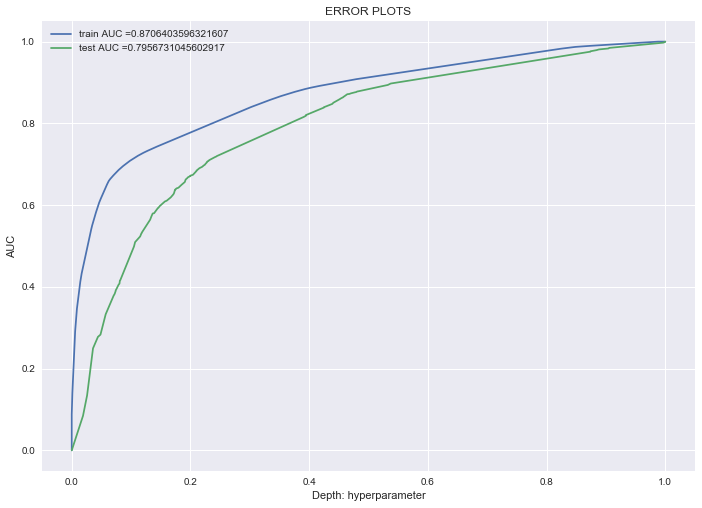

In [57]:
optimal_depth2=20
optimal_split2=350
clf = DecisionTreeClassifier(max_depth = optimal_depth2, class_weight ='balanced', min_samples_split=optimal_split2)
clf.fit(x_train_tf, y_train)

train_fpr_tf, train_tpr_tf, thresholds_tf = roc_curve(y_train, clf.predict_proba(x_train_tf)[:,1])
test_fpr_tf, test_tpr_tf, thresholds_tf = roc_curve(y_test, clf.predict_proba(x_test_tf)[:,1])

plt.plot(train_fpr_tf, train_tpr_tf, label="train AUC ="+str(auc(train_fpr_tf, train_tpr_tf)))
plt.plot(test_fpr_tf, test_tpr_tf, label="test AUC ="+str(auc(test_fpr_tf, test_tpr_tf)))

plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [38]:
clf = DecisionTreeClassifier(max_depth = optimal_depth2, min_samples_split=optimal_split2)
clf.fit(x_train_tf,y_train)

pred = clf.predict(x_test_tf)

acc_2 = accuracy_score(y_test, pred) * 100
pre_2 = precision_score(y_test, pred) * 100
rec_2 = recall_score(y_test, pred) * 100
f1_2  = f1_score(y_test, pred) * 100

print('\nAccuracy = %f%%' % (acc_2))
print('\nprecision= %f%%' % (pre_2))
print('\nrecall   = %f%%' % (rec_2))
print('\nF1-Score = %f%%' % (f1_2))


Accuracy = 85.773963%

precision= 89.068002%

recall   = 94.725919%

F1-Score = 91.809874%


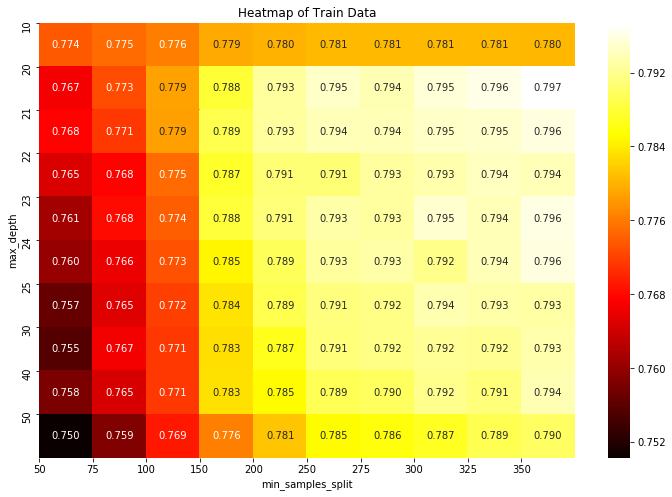

In [39]:
heat_map2 = grid.cv_results_['mean_test_score'].reshape(len(min_split),len(Depths))
plt.figure(figsize=(12,8))
sns.heatmap(heat_map2, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=min_split, yticklabels=Depths)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(min_split)), min_split)
plt.yticks(np.arange(len(Depths)), Depths)
plt.title('Heatmap of Train Data')
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

['not' 'great' 'best' 'delicious' 'love' 'good' 'perfect' 'disappointed'
 'loves' 'nice' 'excellent' 'bad' 'favorite' 'wonderful' 'however' 'awful'
 'find' 'easy' 'unfortunately' 'loved']


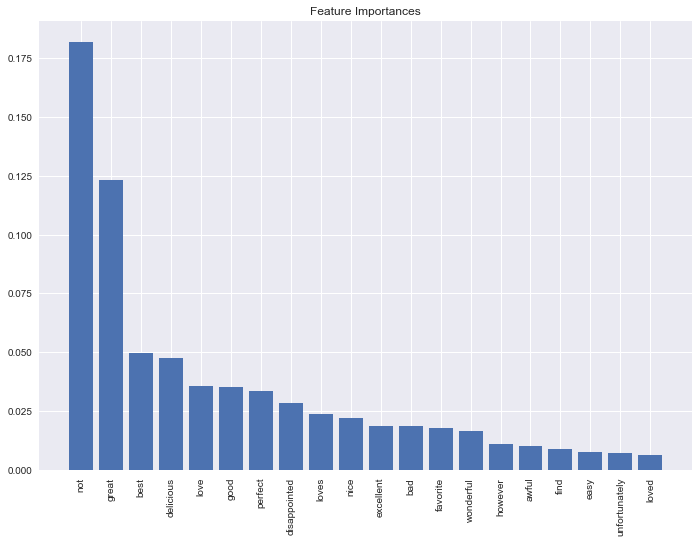

In [58]:
# feature importance
importances = clf.feature_importances_
indices = list(np.argsort(importances)[::-1][:20])
names = np.array(tf_idf.get_feature_names())
print(names[indices])

# plotting feature importances as a simple bargraph
plt.figure()
plt.title("Feature Importances")
plt.bar(range(20), importances[indices])
plt.xticks(range(20), names[indices], rotation=90)
plt.show()

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

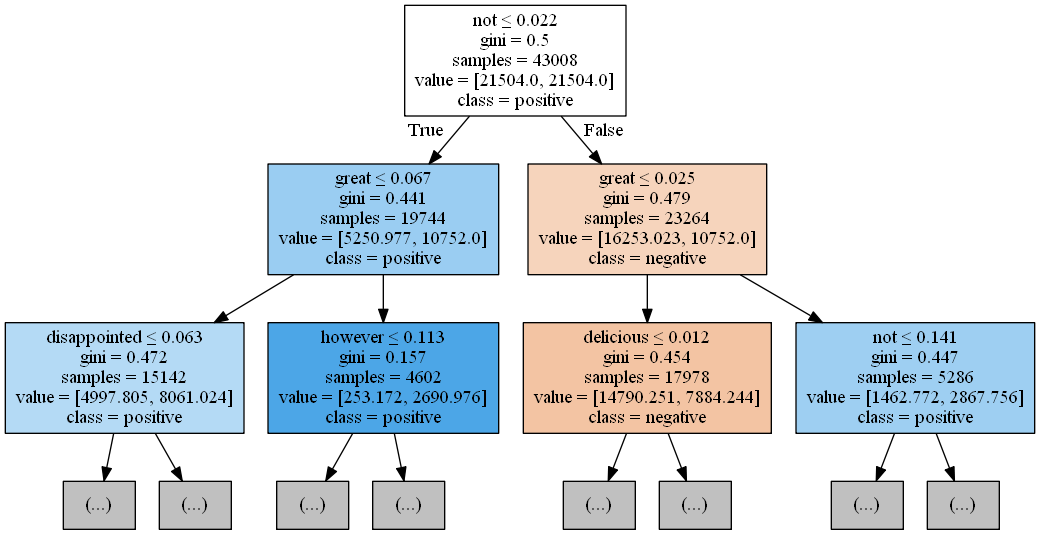

In [59]:
target = ['negative','positive']
# Create DOT data ############# feature_names= names[indices],
data = tree.export_graphviz(clf, max_depth=2, feature_names= names ,out_file=None,class_names=target,filled=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)  

# Show graph
Image(graph.create_png())


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

GridSearch CV implementation on Decision Trees

In [49]:
Depths = [5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
param_grid = {'max_depth':Depths}
clf = DecisionTreeClassifier(min_samples_split=50)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(sent_vectors_train, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_depth3 = grid.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth3)

Accuracy on train data =  50.56925646421963
The optimal number of depth is :  30


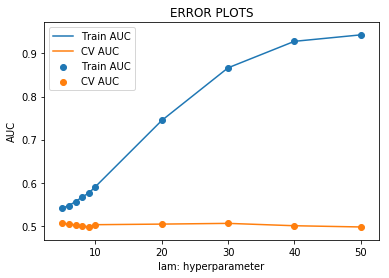

In [50]:
aw2v_auc_train = grid.cv_results_['mean_train_score']
aw2v_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(Depths, aw2v_auc_train, label='Train AUC')
plt.scatter(Depths, aw2v_auc_train, label='Train AUC')

plt.plot(Depths, aw2v_auc_cv, label='CV AUC')
plt.scatter(Depths, aw2v_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with test data

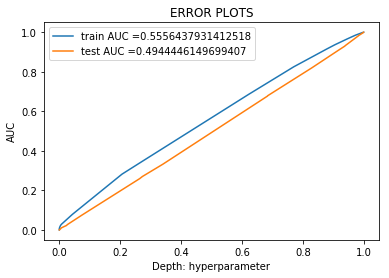

In [51]:
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=50)
clf.fit(sent_vectors_train, y_train)

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(y_train, clf.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(y_test, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Hyperparameter tuning using grid serach cross validation(tuing min_sample_split feature)

In [52]:
min_split = [10, 15, 25, 40, 50, 75, 100, 150, 200, 250]
param_grid = {'min_samples_split': min_split} 
clf = DecisionTreeClassifier(max_depth=5)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(sent_vectors_train, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_split3 = grid.best_estimator_.min_samples_split
print("The optimal number of splits is : ",optimal_split3)

Accuracy on train data =  50.59638832538694
The optimal number of splits is :  10


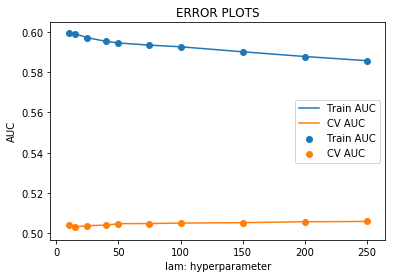

In [75]:
aw2v_auc_train = grid.cv_results_['mean_train_score']
aw2v_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(min_split, aw2v_auc_train, label='Train AUC')
plt.scatter(min_split, aw2v_auc_train, label='Train AUC')

plt.plot(min_split, aw2v_auc_cv, label='CV AUC')
plt.scatter(min_split, aw2v_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with test data

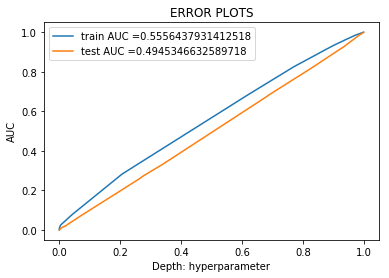

In [54]:
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=10)
clf.fit(sent_vectors_train, y_train)

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(y_train, clf.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(y_test, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [55]:
parameters = {'min_samples_split': min_split,'max_depth': Depths}
grid = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'), parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid.fit(sent_vectors_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 20, 30, 40, 50],
                         'min_samples_split': [10, 15, 25

In [56]:
grid.best_params_

{'max_depth': 5, 'min_samples_split': 10}

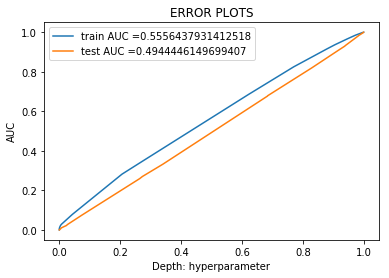

In [57]:
optimal_depth3=5
optimal_split3=10
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=10)
clf.fit(sent_vectors_train, y_train)

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(y_train, clf.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(y_test, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [59]:
clf = DecisionTreeClassifier(max_depth = optimal_depth3, min_samples_split=optimal_split3)
clf.fit(sent_vectors_train,y_train)

pred = clf.predict(sent_vectors_test)

acc_3 = accuracy_score(y_test, pred) * 100
pre_3 = precision_score(y_test, pred) * 100
rec_3 = recall_score(y_test, pred) * 100
f1_3  = f1_score(y_test, pred) * 100

print('\nAccuracy = %f%%' % (acc_3))
print('\nprecision= %f%%' % (pre_3))
print('\nrecall   = %f%%' % (rec_3))
print('\nF1-Score = %f%%' % (f1_3))


Accuracy = 84.076409%

precision= 84.177697%

recall   = 99.851117%

F1-Score = 91.346967%


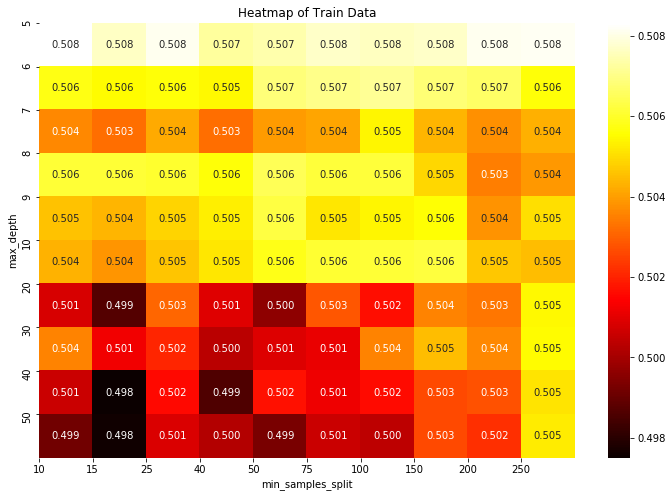

In [61]:
heat_map3 = grid.cv_results_['mean_test_score'].reshape(len(min_split),len(Depths))
plt.figure(figsize=(12,8))
sns.heatmap(heat_map3, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=min_split, yticklabels=Depths)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(min_split)), min_split)
plt.yticks(np.arange(len(Depths)), Depths)
plt.title('Heatmap of Train Data')
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

Hyperparameter tuning using grid serach cross validation for parameter max_depth

In [66]:
Depths = [5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
param_grid = {'max_depth':Depths}
clf = DecisionTreeClassifier(min_samples_split=300)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(tfidf_sent_vectors_train, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_depth4 = grid.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth4)

Accuracy on train data =  50.91359419060575
The optimal number of depth is :  20


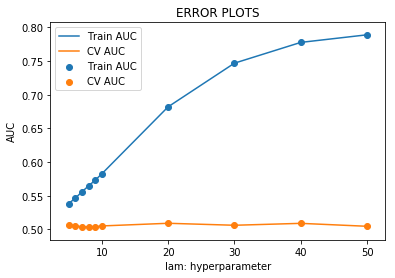

In [67]:
tw2v_auc_train = grid.cv_results_['mean_train_score']
tw2v_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(Depths, tw2v_auc_train, label='Train AUC')
plt.scatter(Depths, tw2v_auc_train, label='Train AUC')

plt.plot(Depths, tw2v_auc_cv, label='CV AUC')
plt.scatter(Depths, tw2v_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with test data

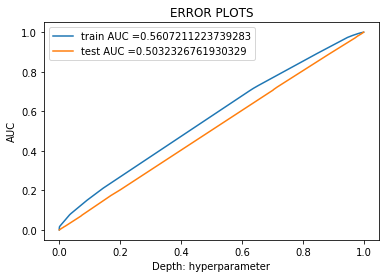

In [70]:
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=10)
clf.fit(tfidf_sent_vectors_train, y_train)

train_fpr_tw2v, train_tpr_tw2v, thresholds_tw2v = roc_curve(y_train, clf.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tw2v, test_tpr_tw2v, thresholds_tw2v = roc_curve(y_test, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tw2v, train_tpr_tw2v, label="train AUC ="+str(auc(train_fpr_tw2v, train_tpr_tw2v)))
plt.plot(test_fpr_tw2v, test_tpr_tw2v, label="test AUC ="+str(auc(test_fpr_tw2v, test_tpr_tw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Hyperparameter tuning using grid search cross validation for paramaeter min_samples_split.

In [71]:
min_split = [10, 15, 25, 40, 50, 75, 100, 150, 200, 250]
param_grid = {'min_samples_split': min_split} 
clf = DecisionTreeClassifier(max_depth=10)

grid = GridSearchCV(clf, param_grid ,cv= 3,n_jobs =-1, scoring='roc_auc', return_train_score=True)
grid.fit(tfidf_sent_vectors_train, y_train)

print("Accuracy on train data = ", grid.best_score_*100)
optimal_split3 = grid.best_estimator_.min_samples_split
print("The optimal number of splits is : ",optimal_split3)

Accuracy on train data =  50.58923114709584
The optimal number of splits is :  250


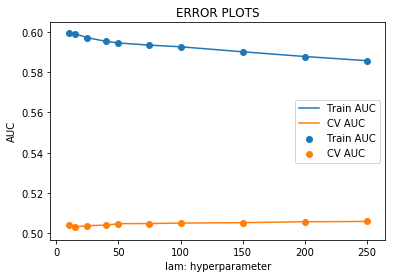

In [73]:
tw2v_auc_train = grid.cv_results_['mean_train_score']
tw2v_auc_cv    = grid.cv_results_['mean_test_score'] 

plt.plot(min_split, tw2v_auc_train, label='Train AUC')
plt.scatter(min_split, tw2v_auc_train, label='Train AUC')

plt.plot(min_split, tw2v_auc_cv, label='CV AUC')
plt.scatter(min_split, tw2v_auc_cv, label='CV AUC')

plt.legend()
plt.xlabel("lam: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing with test data

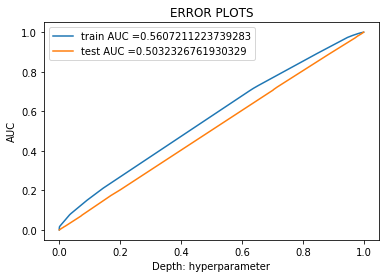

In [76]:
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=10)
clf.fit(tfidf_sent_vectors_train, y_train)

train_fpr_tw2v, train_tpr_tw2v, thresholds_tw2v = roc_curve(y_train, clf.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tw2v, test_tpr_tw2v, thresholds_tw2v = roc_curve(y_test, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tw2v, train_tpr_tw2v, label="train AUC ="+str(auc(train_fpr_tw2v, train_tpr_tw2v)))
plt.plot(test_fpr_tw2v, test_tpr_tw2v, label="test AUC ="+str(auc(test_fpr_tw2v, test_tpr_tw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Tuning both parameters together.

In [77]:
parameters = {'min_samples_split': min_split,'max_depth': Depths}
grid = GridSearchCV(DecisionTreeClassifier(class_weight ='balanced'), parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid.fit(tfidf_sent_vectors_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 20, 30, 40, 50],
                         'min_samples_split': [10, 15, 25

In [78]:
grid.best_params_

{'max_depth': 5, 'min_samples_split': 150}

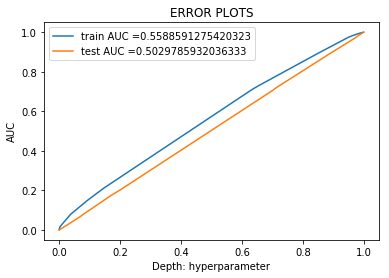

In [80]:
optimal_depth4=5
optimal_split4=150
clf = DecisionTreeClassifier(max_depth = 5, class_weight ='balanced', min_samples_split=150)
clf.fit(tfidf_sent_vectors_train, y_train)

train_fpr_tw2v, train_tpr_tw2v, thresholds_tw2v = roc_curve(y_train, clf.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tw2v, test_tpr_tw2v, thresholds_tw2v = roc_curve(y_test, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tw2v, train_tpr_tw2v, label="train AUC ="+str(auc(train_fpr_tw2v, train_tpr_tw2v)))
plt.plot(test_fpr_tw2v, test_tpr_tw2v, label="test AUC ="+str(auc(test_fpr_tw2v, test_tpr_tw2v)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [82]:
clf = DecisionTreeClassifier(max_depth = optimal_depth4, min_samples_split=optimal_split4)
clf.fit(tfidf_sent_vectors_train,y_train)

pred = clf.predict(tfidf_sent_vectors_test)

acc_4 = accuracy_score(y_test, pred) * 100
pre_4 = precision_score(y_test, pred) * 100
rec_4 = recall_score(y_test, pred) * 100
f1_4  = f1_score(y_test, pred) * 100

print('\nAccuracy = %f%%' % (acc_4))
print('\nprecision= %f%%' % (pre_4))
print('\nrecall   = %f%%' % (rec_4))
print('\nF1-Score = %f%%' % (f1_4))


Accuracy = 84.072611%

precision= 84.171896%

recall   = 99.855628%

F1-Score = 91.345440%


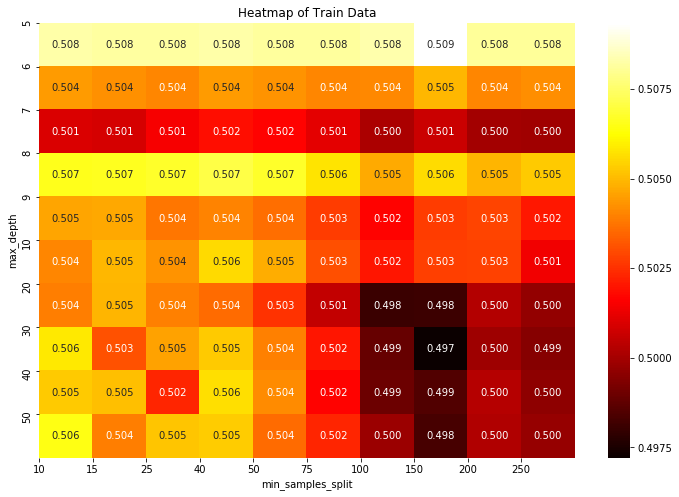

In [83]:
heat_map4 = grid.cv_results_['mean_test_score'].reshape(len(min_split),len(Depths))
plt.figure(figsize=(12,8))
sns.heatmap(heat_map4, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=min_split, yticklabels=Depths)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(min_split)), min_split)
plt.yticks(np.arange(len(Depths)), Depths)
plt.title('Heatmap of Train Data')
plt.show()

# [6] Conclusions

In [93]:
# Please compare all your models using Prettytable library
number   = [1,2,3,4]
name     = ["Bow", "Tfidf", "Avg W2v", "Tfidf W2v"]
op_depth = [optimal_depth1, optimal_depth2, optimal_depth3, optimal_depth4]
op_splits= [optimal_split1, optimal_split2, optimal_split3, optimal_split4]

acc= [acc_1,acc_2,acc_3,acc_4]


#Initialize Prettytable
pt = PrettyTable()
pt.add_column("Index", number)
pt.add_column("Model", name)
pt.add_column("Optimal Depth", op_depth)
pt.add_column("Optimal Splits", op_splits)
pt.add_column("Accuracy%", acc)
print(pt)

+-------+-----------+---------------+----------------+-------------------+
| Index |   Model   | Optimal Depth | Optimal Splits |     Accuracy%     |
+-------+-----------+---------------+----------------+-------------------+
|   1   |    Bow    |       22      |      300       | 85.56888956402857 |
|   2   |   Tfidf   |       20      |      350       |  85.773963238645  |
|   3   |  Avg W2v  |       5       |      250       | 84.07640893209782 |
|   4   | Tfidf W2v |       5       |      150       |  84.0726112714568 |
+-------+-----------+---------------+----------------+-------------------+
